In [205]:
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.core.mutation import Mutation
from pymoo.core.crossover import Crossover
from pymoo.core.sampling import Sampling
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.optimize import minimize

In [206]:
class CustomHybridMutation(Mutation):
    """Custom mutation for permutation (sequence) and integer (machine choices)."""    
    def __init__(self, prob=0.1):
        super().__init__()
        self.prob = prob

    def _do(self, problem, X, **kwargs):
        n_individuals, n_var = X.shape
        # print(f"X shape: {X.shape}")
        # print('X:', X)
        # print('n_individuals:', n_individuals)
        seq_length = problem.seq_length
        n_stages = problem.n_stages
        Y = X.copy()

        for i in range(n_individuals):
            # print('------------------------')
            # Permutation mutation
            if np.random.random() < self.prob:
                # print('before mutation:', Y[i, :seq_length])
                idx1, idx2 = np.random.choice(seq_length, size=2, replace=False)
                Y[i, :seq_length][[idx1, idx2]] = Y[i, :seq_length][[idx2, idx1]]
                # print('after mutation:', Y[i, :seq_length])
            # Machine choice mutation
            machine_choices = Y[i, seq_length:].reshape(seq_length, n_stages)
            # print('before machine mutation: \n', machine_choices)
            for j in range(seq_length):
                for s in range(n_stages):
                    if np.random.random() < self.prob:
                        machine_choices[j, s] = np.random.randint(0, problem.machines_per_stage[s])
            Y[i, seq_length:] = machine_choices.flatten()
            # print('after machine mutation: \n', Y[i, seq_length:].reshape(seq_length, n_stages))

        return Y.astype(int)

class CustomHybridCrossover(Crossover):
    """Custom crossover for permutation and integer parts."""    
    def __init__(self, prob=0.5):
        super().__init__(2, 2)
        self.prob = prob
        self.order_cx = OrderCrossover()
        self.uniform_cx = UniformCrossover(prob=prob)

    def _do(self, problem, X, **kwargs):
        n_parents, n_matings, n_var = X.shape
        # print(f"X shape: {X.shape}")
        # print('X:', X)
        # print('n_matings:', n_matings)
        seq_length = problem.seq_length
        Y = np.zeros_like(X)

        for k in range(n_matings):
            a, b = X[:, k, :]
            # print('------------------------')
            # print(f"Parent A: {a}")
            # print(f"Parent B: {b}")
            perm_a, perm_b = self.order_cx._do(problem, np.array([[a[:seq_length]], [b[:seq_length]]]))[:, 0, :]
            # print(f"Permuted A: {perm_a}")
            # print(f"Permuted B: {perm_b}")
            machine_a, machine_b = self.uniform_cx._do(problem, np.array([[a[seq_length:]], [b[seq_length:]]]))[:, 0, :]
            # print(f"Machine A: {machine_a}")
            # print(f"Machine B: {machine_b}")
            Y[0, k, :seq_length] = perm_a
            Y[1, k, :seq_length] = perm_b
            Y[0, k, seq_length:] = machine_a
            Y[1, k, seq_length:] = machine_b

        return Y.astype(int)

class CustomHybridSampling(Sampling):
    """Custom sampling for permutation and integer parts."""    
    def _do(self, problem, n_samples, **kwargs):
        seq_length = problem.seq_length
        n_stages = problem.n_stages
        X = np.zeros((n_samples, problem.n_var), dtype=int)

        for i in range(n_samples):
            X[i, :seq_length] = np.random.permutation(seq_length)
            machine_choices = np.zeros((seq_length, n_stages), dtype=int)
            for j in range(seq_length):
                for s in range(n_stages):
                    machine_choices[j, s] = np.random.randint(0, problem.machines_per_stage[s])
            X[i, seq_length:] = machine_choices.flatten()

        return X

In [207]:
class BakeryHybridSchedulingProblem(Problem):
    def __init__(self, user_sequence, recipe_id_to_index, machines_per_stage, processing_times, changeover_times, batch_sizes, tact_times, debug=False):
        self.seq_length = len(user_sequence)
        self.user_sequence = np.array(user_sequence)
        self.recipe_id_to_index = recipe_id_to_index
        self.n_stages = len(machines_per_stage)
        self.machines_per_stage = machines_per_stage
        self.max_makespan = 0
        self.max_machines = max(machines_per_stage)
        self.debug = debug
        n_var = self.seq_length + (self.seq_length * self.n_stages)
        super().__init__(
            n_var=n_var,
            n_obj=1,
            n_constr=0,
            xl=[0] * n_var,
            xu=[self.seq_length - 1] * self.seq_length + [m - 1 for m in machines_per_stage for _ in range(self.seq_length)],
            type_var=int
        )
        self.processing_times = processing_times
        self.changeover_times = changeover_times
        self.batch_sizes = batch_sizes
        self.tact_times = tact_times

    def _evaluate(self, X, out, *args, **kwargs):
        makespans = np.array([self.calculate_makespan(x, store_best=False) for x in X])
        out["F"] = makespans

    def calculate_makespan(self, x, store_best=True):
        # Unpack Solution
        perm = x[:self.seq_length]
        machine_choices = x[self.seq_length:].reshape(self.seq_length, self.n_stages)
        seq = self.user_sequence[perm]
        permuted_batch_sizes = np.array(self.batch_sizes)[perm]

        # Initialize Tracking Arrays
        start_times = np.zeros((self.seq_length, self.n_stages))
        end_times = np.zeros((self.seq_length, self.n_stages))
        changeover_times_array = np.zeros((self.seq_length, self.n_stages))
        machine_free_times = np.zeros((self.n_stages, self.max_machines))
        postponement = 0  # For no-wait constraint violation correction

        for i in range(self.seq_length):
            recipe = seq[i]
            perm_batch_size = permuted_batch_sizes[i]

            # --- Stage 0 ---
            s = 0
            m = machine_choices[i, s]
            # Changeover must finish before start
            last_job_on_machine = None
            for j in range(i - 1, -1, -1):
                if machine_choices[j, s] == m:
                    last_job_on_machine = j
                    break
            if last_job_on_machine is None:
                changeover = 0
            else:
                prev_recipe_on_machine = seq[last_job_on_machine]
                if prev_recipe_on_machine != recipe:
                    changeover = self.changeover_times[s, m, prev_recipe_on_machine, recipe]
                    changeover = changeover.item() if isinstance(changeover, np.ndarray) else changeover
                else:
                    changeover = 0
            changeover_times_array[i, s] = changeover

            # Start time is when machine is free and changeover is done
            start_times[i, s] = max(0, machine_free_times[s, m])
            if last_job_on_machine is not None:
                # Ensure changeover is done before start
                start_times[i, s] = max(start_times[i, s], end_times[last_job_on_machine, s] + changeover)
            else:
                start_times[i, s] = max(start_times[i, s], changeover)
            # Apply any postponement from no-wait violation correction
            start_times[i, s] += postponement

            processing_duration = self.processing_times[s, m, recipe]
            batch_delay = (perm_batch_size - 1) * self.tact_times[recipe]
            end_times[i, s] = start_times[i, s] + processing_duration + batch_delay
            machine_free_times[s, m] = end_times[i, s]

            if self.debug and store_best:
                print('--'*10)
                print('Stage 0 calculations:')
                print('i', i)
                print('s = 0')
                print('m', m)
                print('processing_duration', processing_duration)
                print('changeover_times_array[i, s]', changeover_times_array[i, s])
                print('start_times[i, s]', start_times[i, s])
                print('machine_free_times[s, m]', machine_free_times[s, m])
                print('permuted_batch_sizes[i]', permuted_batch_sizes[i])
                print('--'*10)

            # --- Subsequent Stages ---
            for s in range(1, self.n_stages):
                m = machine_choices[i, s]
                # Changeover
                last_job_on_machine = None
                for j in range(i - 1, -1, -1):
                    if machine_choices[j, s] == m:
                        last_job_on_machine = j
                        break
                if last_job_on_machine is None:
                    changeover = 0
                else:
                    prev_recipe_on_machine = seq[last_job_on_machine]
                    if prev_recipe_on_machine != recipe:
                        changeover = self.changeover_times[s, m, prev_recipe_on_machine, recipe]
                        changeover = changeover.item() if isinstance(changeover, np.ndarray) else changeover
                    else:
                        changeover = 0
                changeover_times_array[i, s] = changeover

                # No-wait: must start as soon as previous stage ends
                required_start = end_times[i, s - 1] - (perm_batch_size - 1) * self.tact_times[recipe]
                # Changeover must finish before required_start
                if last_job_on_machine is not None:
                    ready_time = end_times[last_job_on_machine, s] + changeover
                else:
                    ready_time = changeover
                start_times[i, s] = max(required_start, ready_time, machine_free_times[s, m])

                # If the machine is not ready at required_start, we must postpone the whole job at Stage 0
                if start_times[i, s] > required_start:
                    # Calculate how much to postpone
                    postpone_amount = start_times[i, s] - required_start
                    # Apply postponement to Stage 0 and recalculate all stages for this job
                    start_times[i, 0] += postpone_amount
                    end_times[i, 0] += postpone_amount
                    for ss in range(1, s + 1):
                        start_times[i, ss] += postpone_amount
                        end_times[i, ss] += postpone_amount
                    # Update machine_free_times for all previous stages for this job
                    for ss in range(s):
                        m_prev = machine_choices[i, ss]
                        machine_free_times[ss, m_prev] = end_times[i, ss]
                    # Now, set required_start to new value
                    required_start = end_times[i, s - 1] - (perm_batch_size - 1) * self.tact_times[recipe]
                    start_times[i, s] = max(required_start, ready_time, machine_free_times[s, m])

                processing_duration = self.processing_times[s, m, recipe]
                batch_delay = (perm_batch_size - 1) * self.tact_times[recipe]
                end_times[i, s] = start_times[i, s] + processing_duration + batch_delay
                machine_free_times[s, m] = end_times[i, s]

            if self.debug and store_best:
                for s in range(self.n_stages):
                    m = machine_choices[i, s]
                    print(f"Recipe {i} (ID {recipe_ids[recipe]}): Stage {s}, Machine {m}: "
                          f"Start = {start_times[i, s]}, Changeover = {changeover_times_array[i, s]}, "
                          f"Processing = {self.processing_times[s, m, recipe]}, Batch Delay = {batch_delay}, "
                          f"End = {end_times[i, s]}, Machine free at = {machine_free_times[s, m]}")

        makespan = np.max(end_times)
    
        if store_best:
            self.best_start_times = start_times
            self.best_end_times = end_times
            self.best_machine_choices = machine_choices
            self.best_sequence_ids = [recipe_ids[idx] for idx in seq]
            self.best_changeover_times = changeover_times_array
            self.max_makespan = makespan

        return makespan


    def plot_gantt_chart(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        stage_labels = [f"Stage {s} (Machine {m})" for s in range(self.n_stages) for m in range(self.machines_per_stage[s])]
        y_positions = np.arange(len(stage_labels))
        colors = {recipe_id: plt.cm.Set3(i) for i, recipe_id in enumerate(np.unique(self.best_sequence_ids))}

        # Build job labels with occurrence numbers
        recipe_counts = defaultdict(int)
        recipe_total_counts = Counter(self.best_sequence_ids)
        job_labels = []
        for rid in self.best_sequence_ids:
            recipe_counts[rid] += 1
            if recipe_total_counts[rid] > 1:
                job_labels.append(f"{rid} ({recipe_counts[rid]})")
            else:
                job_labels.append(f"{rid}")

        # Add striped background for each stage
        stage_start_idx = 0
        for s in range(self.n_stages):
            n_machines = self.machines_per_stage[s]
            stage_end_idx = stage_start_idx + n_machines
            if s % 2 == 0:
                ax.axhspan(stage_start_idx - 0.5, stage_end_idx - 0.5, facecolor="#ffffff", alpha=0.5, zorder=0)
            else:
                ax.axhspan(stage_start_idx - 0.5, stage_end_idx - 0.5, facecolor='#f5f5dc', alpha=0.5, zorder=0)
            stage_start_idx = stage_end_idx

        for i in range(self.seq_length):
            recipe_id = self.best_sequence_ids[i]
            label = job_labels[i]
            for s in range(self.n_stages):
                m = self.best_machine_choices[i, s]
                stage_idx = sum(self.machines_per_stage[:s]) + m
                if self.best_start_times[i, s] < self.best_end_times[i, s]:
                    if self.best_changeover_times[i, s] > 0:
                        ax.barh(y_positions[stage_idx], self.best_changeover_times[i, s],
                                left=self.best_start_times[i, s], height=0.5, color='red', edgecolor='black', alpha=0.7,
                                label='Changeover' if i == 0 and s == 0 else "")
                        process_start = self.best_start_times[i, s] + self.best_changeover_times[i, s]
                    else:
                        process_start = self.best_start_times[i, s]
                    process_duration = ((self.best_end_times[i, s] - self.best_start_times[i, s]) -
                                        self.best_changeover_times[i, s])

                    ax.barh(y_positions[stage_idx], process_duration,
                            left=process_start, height=0.5, color=colors[recipe_id], edgecolor='black')
                    # Use job label instead of just recipe_id
                    ax.text(process_start + process_duration / 2, y_positions[stage_idx], label,
                            ha='center', va='center', color='white', fontweight='bold')

        ax.set_yticks(y_positions)
        ax.set_yticklabels(stage_labels)
        ax.set_xlabel("Time")
        ax.set_title("Batch Production Scheduling - Multi-stage Flowshop Optimization")
        ax.set_xlim(0, self.max_makespan + 10)
        ax.set_ylim(-0.5, len(stage_labels) - 0.5)
        handles = [plt.Rectangle((0,0),1,1, color=colors[rid], label=str(rid)) for rid in colors.keys()]
        handles.append(plt.Rectangle((0,0),1,1, color='red', alpha=0.7, label='Changeover'))
        ax.legend(handles=handles, loc='best', title="Recipe IDs")
        plt.tight_layout()
        plt.show()

In [208]:
# Example setup
recipe_ids = [1, 3, 4, 5, 8, 14]
recipe_id_to_index = {rid: idx for idx, rid in enumerate(recipe_ids)}

# User's sequence (8 positions)
user_sequence_ids = [3, 1, 5, 8, 14, 3, 5, 5]
user_sequence_idx = [recipe_id_to_index[rid] for rid in user_sequence_ids]

# Problem parameters
n_stages = 5
n_recipes = len(recipe_ids)
machines_per_stage = [1, 2, 1, 2, 3]
max_machines = max(machines_per_stage)

# Sample data
np.random.seed(42)

# processing_times = np.random.randint(5, 20, size=(n_stages, max_machines, n_recipes))
base_processing_times = np.random.randint(5, 20, size=(n_stages, n_recipes))
processing_times = np.repeat(base_processing_times[:, np.newaxis, :], max_machines, axis=1)

changeover_times = np.random.randint(1, 5, size=(n_stages, max_machines, n_recipes, n_recipes))
for s in range(n_stages):
    for m in range(machines_per_stage[s]):
        for i in range(n_recipes):
            changeover_times[s, m, i, i] = 0  # No changeover for same recipe
            
# Define batch_sizes to match the sequence length
batch_sizes = [10, 20, 15, 5, 30, 15, 25, 25]  # Example quantities for each position in the user_sequence
# tact_times = np.random.uniform(0.5, 2.0, size=n_recipes)
tact_times = np.random.randint(1, 2, size=n_recipes)

# Debug print input data
print("recipe_ids:", recipe_ids)
print("recipe_id_to_index:", recipe_id_to_index)
print("User sequence IDs:", user_sequence_ids)
print("User sequence indices:", user_sequence_idx)
print("\n")
print("Batch sizes:", batch_sizes)
print("Tact times:", tact_times)
print("\n")
print("Base_processing_times:\n", base_processing_times)
print("Processing times:\n", processing_times)
print("Changeover times:\n", changeover_times)

recipe_ids: [1, 3, 4, 5, 8, 14]
recipe_id_to_index: {1: 0, 3: 1, 4: 2, 5: 3, 8: 4, 14: 5}
User sequence IDs: [3, 1, 5, 8, 14, 3, 5, 5]
User sequence indices: [1, 0, 3, 4, 5, 1, 3, 3]


Batch sizes: [10, 20, 15, 5, 30, 15, 25, 25]
Tact times: [1 1 1 1 1 1]


Base_processing_times:
 [[11  8 17 19 15 12]
 [17  9 11 14  7 11]
 [15 15 12  9  8 12]
 [12  7 10  9  6 12]
 [16 18 10  6 16  9]]
Processing times:
 [[[11  8 17 19 15 12]
  [11  8 17 19 15 12]
  [11  8 17 19 15 12]]

 [[17  9 11 14  7 11]
  [17  9 11 14  7 11]
  [17  9 11 14  7 11]]

 [[15 15 12  9  8 12]
  [15 15 12  9  8 12]
  [15 15 12  9  8 12]]

 [[12  7 10  9  6 12]
  [12  7 10  9  6 12]
  [12  7 10  9  6 12]]

 [[16 18 10  6 16  9]
  [16 18 10  6 16  9]
  [16 18 10  6 16  9]]]
Changeover times:
 [[[[0 4 2 2 1 4]
   [1 0 3 3 3 2]
   [4 4 0 4 3 2]
   [2 3 2 0 4 3]
   [4 4 1 3 0 3]
   [3 1 1 3 2 0]]

  [[1 4 2 2 2 1]
   [2 1 2 4 4 3]
   [4 3 4 1 4 3]
   [3 2 1 4 2 4]
   [4 2 2 2 2 2]
   [4 2 1 3 2 2]]

  [[4 2 2 2 4 2]
   [3 4 3

In [209]:
def minimize_machines_postprocess(problem):
    """
    Try to reassign jobs to fewer machines per stage, without increasing waiting times.
    Updates problem.best_machine_choices in place.
    """

    machine_choices = problem.best_machine_choices.copy()
    start_times = problem.best_start_times
    end_times = problem.best_end_times
    seq_length, n_stages = machine_choices.shape
    machines_per_stage = problem.machines_per_stage

    for s in range(n_stages):
        # For each stage, try to assign jobs to as few machines as possible
        recipe_idx_sorted = np.argsort(start_times[:, s])
        print('sorted jobs for stage', s, ':', recipe_idx_sorted)
        print('sorted recipe ids for stage', s, ':', [problem.best_sequence_ids[j] for j in recipe_idx_sorted])
        assigned = [False] * seq_length
        new_assignments = np.full(seq_length, -1)
        machine_end_times = [0] * machines_per_stage[s]
        used_machines = []

        for recipe_idx in recipe_idx_sorted:
            # Try to assign to an already used machine if possible
            assigned_flag = False
            for m in used_machines:
                # Can this job start after the last job on this machine finished?
                last_end = machine_end_times[m]
                if start_times[recipe_idx, s] >= last_end:
                    new_assignments[recipe_idx] = m
                    machine_end_times[m] = end_times[recipe_idx, s]
                    assigned_flag = True
                    break
            if not assigned_flag:
                # Assign to a new machine
                for m in range(machines_per_stage[s]):
                    if m not in used_machines:
                        new_assignments[recipe_idx] = m
                        machine_end_times[m] = end_times[recipe_idx, s]
                        used_machines.append(m)
                        break

        # Update machine choices for this stage
        machine_choices[:, s] = new_assignments

    # Update the problem with the new machine assignments
    problem.best_machine_choices = machine_choices

    # Optionally, recompute makespan and times for consistency
    # (if you want to update Gantt chart, etc.)
    # You may want to call:
    problem.calculate_makespan(np.concatenate([problem.best_perm, machine_choices.flatten()]), store_best=True)

    print("Post-processing complete. New machine assignments minimize machine usage per stage.")


In [210]:
# Create the problem instance
problem = BakeryHybridSchedulingProblem(
    user_sequence=user_sequence_idx,
    recipe_id_to_index=recipe_id_to_index,
    machines_per_stage=machines_per_stage,
    processing_times=processing_times,
    changeover_times=changeover_times,
    batch_sizes=batch_sizes,
    tact_times=tact_times,
    debug=True
)

# Define the genetic algorithm
algorithm = GA(
    pop_size=100,
    sampling=CustomHybridSampling(),
    crossover=CustomHybridCrossover(prob=0.5),
    mutation=CustomHybridMutation(prob=0.1),
    eliminate_duplicates=True
)

# Define termination criteria
termination = DefaultSingleObjectiveTermination(
    xtol=1e-6,
    cvtol=1e-6,
    ftol=1e-6,
    period=50,
    n_max_gen=200
)

# Run the optimization
res = minimize(
    problem,
    algorithm,
    termination,
    seed=42,
    verbose=True
)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      100 |  3.313900E+02 |  3.070000E+02
     2 |      200 |  3.216500E+02 |  3.060000E+02
     3 |      300 |  3.163800E+02 |  3.040000E+02
     4 |      400 |  3.129000E+02 |  3.030000E+02
     5 |      500 |  3.099000E+02 |  3.030000E+02
     6 |      600 |  3.077500E+02 |  3.030000E+02


c:\Users\FS122375\Documents\schantt-model\.venv\Lib\site-packages\pymoo\util\normalization.py:86: RuntimeWarning: invalid value encountered in cast
  N[..., neither_nan] = (X[..., neither_nan] - xl[neither_nan]) / (xu[neither_nan] - xl[neither_nan])


     7 |      700 |  3.060500E+02 |  3.030000E+02
     8 |      800 |  3.050700E+02 |  3.030000E+02
     9 |      900 |  3.042600E+02 |  3.030000E+02
    10 |     1000 |  3.035200E+02 |  3.030000E+02
    11 |     1100 |  3.030900E+02 |  3.030000E+02
    12 |     1200 |  3.030000E+02 |  3.030000E+02
    13 |     1300 |  3.030000E+02 |  3.030000E+02
    14 |     1400 |  3.030000E+02 |  3.030000E+02
    15 |     1500 |  3.030000E+02 |  3.030000E+02
    16 |     1600 |  3.030000E+02 |  3.030000E+02
    17 |     1700 |  3.030000E+02 |  3.030000E+02
    18 |     1800 |  3.030000E+02 |  3.030000E+02
    19 |     1900 |  3.030000E+02 |  3.030000E+02
    20 |     2000 |  3.030000E+02 |  3.030000E+02
    21 |     2100 |  3.030000E+02 |  3.030000E+02
    22 |     2200 |  3.030000E+02 |  3.030000E+02
    23 |     2300 |  3.030000E+02 |  3.030000E+02
    24 |     2400 |  3.030000E+02 |  3.030000E+02
    25 |     2500 |  3.030000E+02 |  3.030000E+02
    26 |     2600 |  3.030000E+02 |  3.030000E+02


--------------------
Stage 0 calculations:
i 0
s = 0
m 0
processing_duration 8
changeover_times_array[i, s] 0.0
start_times[i, s] 0.0
machine_free_times[s, m] 17.0
permuted_batch_sizes[i] 10
--------------------
Recipe 0 (ID 3): Stage 0, Machine 0: Start = 0.0, Changeover = 0.0, Processing = 8, Batch Delay = 9, End = 17.0, Machine free at = 17.0
Recipe 0 (ID 3): Stage 1, Machine 1: Start = 8.0, Changeover = 0.0, Processing = 9, Batch Delay = 9, End = 26.0, Machine free at = 26.0
Recipe 0 (ID 3): Stage 2, Machine 0: Start = 17.0, Changeover = 0.0, Processing = 15, Batch Delay = 9, End = 41.0, Machine free at = 41.0
Recipe 0 (ID 3): Stage 3, Machine 0: Start = 32.0, Changeover = 0.0, Processing = 7, Batch Delay = 9, End = 48.0, Machine free at = 48.0
Recipe 0 (ID 3): Stage 4, Machine 0: Start = 39.0, Changeover = 0.0, Processing = 18, Batch Delay = 9, End = 66.0, Machine free at = 66.0
--------------------
Stage 0 calculations:
i 1
s = 0
m 0
processing_duration 15
changeover_times_array[

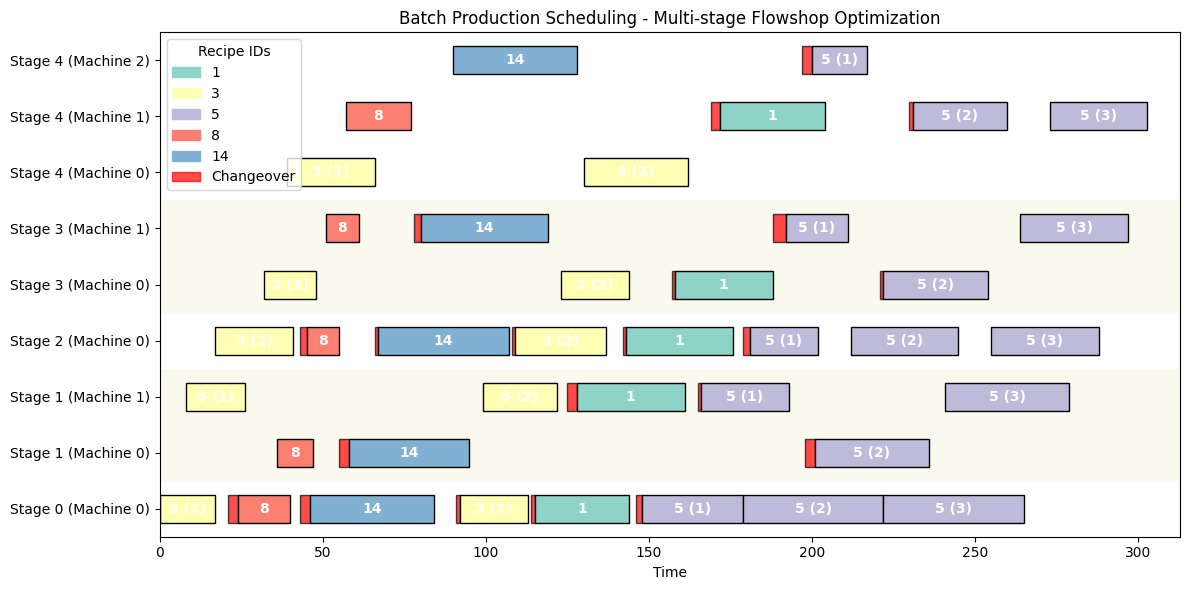

In [211]:
# --- Extract and display results ---

# Get the best solution from the optimizer
best_x = res.X
best_perm = best_x[:problem.seq_length]
# best_x[:problem.seq_length] = np.array([1, 1, 4, 5, 0, 3, 3, 3])

# Recompute and store the makespan and all best_* attributes
makespan = problem.calculate_makespan(best_x, store_best=True)
problem.best_perm = best_perm  # Store for possible later use

# Post-process to minimize machine usage (Optional)
print("Unique machines used per stage BEFORE post-processing:")
for s in range(problem.n_stages):
    unique_machines = np.unique(problem.best_machine_choices[:, s])
    print(f"Stage {s}: {len(unique_machines)} machines used: {unique_machines}")

# minimize_machines_postprocess(problem)

print("Unique machines used per stage AFTER post-processing:")
for s in range(problem.n_stages):
    unique_machines = np.unique(problem.best_machine_choices[:, s])
    print(f"Stage {s}: {len(unique_machines)} machines used: {unique_machines}")

# Print summary of the best solution
print("Original sequence of recipe IDs:", user_sequence_ids)
print("Best permutation of indices:", best_perm)
print("Best sequence of recipe IDs:", problem.best_sequence_ids)
print("Best machine choices per recipe and stage:\n", problem.best_machine_choices)
print("Best makespan:", problem.max_makespan)

# Visualize the schedule
problem.plot_gantt_chart()

In [212]:
print('best_x:', best_x)

# replace best_x recipe_idx with np.array([1, 1, 4, 5, 0, 3, 3, 3])
best_x[:problem.seq_length] = np.array([1, 1, 4, 5, 0, 3, 3, 3])

print('best_x after replacement:', best_x)

best_x: [0 3 4 5 1 2 7 6 0 1 0 0 0 0 0 0 1 1 0 0 0 1 2 0 1 0 0 0 0 1 0 0 1 0 1 0 1
 2 0 0 0 0 1 0 1 0 1 1]
best_x after replacement: [1 1 4 5 0 3 3 3 0 1 0 0 0 0 0 0 1 1 0 0 0 1 2 0 1 0 0 0 0 1 0 0 1 0 1 0 1
 2 0 0 0 0 1 0 1 0 1 1]


In [213]:
print('best_perm', best_perm)
print('best_sequence_ids', problem.best_sequence_ids)
print('best_machine_choices', problem.best_machine_choices)

best_perm [1 1 4 5 0 3 3 3]
best_sequence_ids [3, 8, 14, 3, 1, 5, 5, 5]
best_machine_choices [[0 1 0 0 0]
 [0 0 0 1 1]
 [0 0 0 1 2]
 [0 1 0 0 0]
 [0 1 0 0 1]
 [0 1 0 1 2]
 [0 0 0 0 1]
 [0 1 0 1 1]]


In [214]:
id_sequence = np.array([3, 3, 8, 14, 1, 5, 5, 5])
#convert id_sequence to indices
id_sequence_indices = np.array([recipe_id_to_index[rid] for rid in id_sequence])

id_sequence_indices
np.array([1, 1, 4, 5, 0, 3, 3, 3])

array([1, 1, 4, 5, 0, 3, 3, 3])

In [215]:
print("Processing time for recipe ID 3 on Stage 0, Machine 0:", processing_times[0, 0, recipe_id_to_index[3]])

Processing time for recipe ID 3 on Stage 0, Machine 0: 8


In [216]:
tact_times[recipe_id_to_index[8]]


np.int32(1)

In [217]:
Before

Recipe 1 (ID 1): Stage 0, Machine 0: Start = 23.0, Changeover = 1.0, Processing = 11, Batch Delay = 19, End = 53.0, Machine free at = 53.0
Recipe 1 (ID 1): Stage 1, Machine 0: Start = 34.0, Changeover = 0.0, Processing = 17, Batch Delay = 19, End = 70.0, Machine free at = 70.0
Recipe 1 (ID 1): Stage 2, Machine 0: Start = 51.0, Changeover = 1.0, Processing = 15, Batch Delay = 19, End = 85.0, Machine free at = 85.0
Recipe 1 (ID 1): Stage 3, Machine 0: Start = 66.0, Changeover = 1.0, Processing = 12, Batch Delay = 19, End = 97.0, Machine free at = 97.0
Recipe 1 (ID 1): Stage 4, Machine 0: Start = 78.0, Changeover = 4.0, Processing = 16, Batch Delay = 19, End = 113.0, Machine free at = 113.0

SyntaxError: invalid syntax (1393008245.py, line 3)

In [ ]:
After

Recipe 1 (ID 1): Stage 0, Machine 0: Start = 23.0, Changeover = 1.0, Processing = 11, Batch Delay = 19, End = 53.0, Machine free at = 53.0
Recipe 1 (ID 1): Stage 1, Machine 0: Start = 34.0, Changeover = 0.0, Processing = 17, Batch Delay = 19, End = 70.0, Machine free at = 70.0
Recipe 1 (ID 1): Stage 2, Machine 0: Start = 51.0, Changeover = 1.0, Processing = 15, Batch Delay = 19, End = 85.0, Machine free at = 85.0
Recipe 1 (ID 1): Stage 3, Machine 0: Start = 66.0, Changeover = 1.0, Processing = 12, Batch Delay = 19, End = 97.0, Machine free at = 97.0
Recipe 1 (ID 1): Stage 4, Machine 0: Start = 78.0, Changeover = 4.0, Processing = 16, Batch Delay = 19, End = 113.0, Machine free at = 113.0


SyntaxError: invalid syntax (545004812.py, line 3)